In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
%matplotlib inline
np.set_printoptions(suppress=True)

In [2]:
categories = None  # ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [3]:
TOKEN_PAT = r'\b[^(\W|\d|_)]{1,}\w\w+\b'
cnt_vecr = CountVectorizer(stop_words='english', min_df=0.005, max_df=0.2, token_pattern=TOKEN_PAT)
dtm = cnt_vecr.fit_transform(newsgroups_train.data)
print('{} documents'.format(dtm.shape[0]))
dtm = dtm[np.asarray(dtm.sum(axis=1)).squeeze() > 6, :]  # no pointless docs in training
print('{} useful documents'.format(dtm.shape[0]))

vectors_tfidf = TfidfTransformer().fit_transform(dtm)
vocab = cnt_vecr.get_feature_names()
P_term = dtm.sum(axis=0) / dtm.sum()
print('{} terms in vocab'.format(len(vocab)))

# vectorizer_tfidf = TfidfVectorizer(stop_words='english', min_df=0.001, max_df=0.5)
# vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)
# vocab = np.array(vectorizer_tfidf.get_feature_names())

11314 documents
9764 useful documents
2246 terms in vocab


In [50]:
num_top_words=15

# there is a mistake here for lbd != 1
def show_topics(topic_term_mat, P_term=P_term, vocab=vocab, lbd=1):
    # use weighting scheme from pyldavis
    a = np.asarray(
        lbd * topic_term_mat + (1 - lbd) * np.multiply(topic_term_mat, 1 / P_term.reshape(1, -1)))
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = [top_words(t) for t in a]
    topic_list = [' '.join(t) for t in topic_words]
    for i, t in enumerate(topic_list):
        print('{:2d}: {}'.format(i, t))
    return topic_list

## sklearn NMF

In [5]:
m,n=vectors_tfidf.shape
d=20  # num topics

# beta_loss: 1 = kullback-leibler, 2 = frobenius-norm
clf = decomposition.NMF(n_components=d, random_state=1, solver='mu', beta_loss=2)

%time W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

CPU times: user 1.87 s, sys: 2.89 s, total: 4.76 s
Wall time: 1.28 s


In [29]:
_ = show_topics(H1)

 0: crazy reaction funny sick bother curious shit huh brain damn hmmm joke admit stupid thread
 1: windows microsoft dos desktop printer setup sys utilities utility thanx mouse font fonts characters drivers
 2: heaven sin christ lord eternal scripture god jesus faith bible doctrine mary christians christianity spirit
 3: dsl n3jxp chastity geb shameful cadre intellect skepticism surrender pitt gordon banks soon patients brain
 4: pitching scored playoffs playoff players fans baseball rangers nhl teams games game score hockey team
 5: ide boot drive drives floppy scsi controller meg motherboard external quadra isa brand disk internal
 6: advance thanks appreciate appreciated replies hello greatly mail wondering netters mailing responses reply anybody looking
 7: escrow encrypted phones clipper keys crypto nsa key chip cellular scheme algorithm encryption session des
 8: argic serdar armenia genocide turks armenians armenian turkey turkish muslim soviet bodies nazi region destroyed
 9: c

## anchor word NMF

In [7]:
from anchors import findAnchors
from sklearn.decomposition.nmf import non_negative_factorization
from sklearn.preprocessing import normalize
from scipy import sparse
import time

In [8]:
class Params:
    def __init__(self, filename):
        self.log_prefix = None
        self.checkpoint_prefix = None
        self.seed = int(time.time())

        with open(filename, "rt") as f:
            for l in f:
                if l == "\n" or l[0] == "#":
                    continue
                l = l.strip()
                l = l.split("=")
                if l[0] == "log_prefix":
                    self.log_prefix = l[1]
                elif l[0] == "max_threads":
                    self.max_threads = int(l[1])
                elif l[0] == "eps":
                    self.eps = float(l[1])
                elif l[0] == "checkpoint_prefix":
                    self.checkpoint_prefix = l[1]
                elif l[0] == "new_dim":
                    self.new_dim = int(l[1])
                elif l[0] == "seed":
                    self.seed = int(l[1])
                elif l[0] == "anchor_thresh":
                    self.anchor_thresh = int(l[1])
                elif l[0] == "top_words":
                    self.top_words = int(l[1])

params = Params('settings.example')

In [9]:
M = dtm.T.tocsc().astype(float)
print('{} words / {} documents'.format(*M.shape))

print("identifying candidate anchors")
candidate_anchors = []

# only accept anchors that appear in a significant number of docs
for i in range(M.shape[0]):
    if len(np.nonzero(M[i, :])[1]) > params.anchor_thresh:
        candidate_anchors.append(i)

print(len(candidate_anchors), "candidates")

2246 words / 9764 documents
identifying candidate anchors
1214 candidates


In [39]:
# forms Q matrix from document-word matrix

# Qorg = generate_Q_matrix(M)
vocab_sz = M.shape[0]
doclengths = np.array(M.sum(axis=0))
H = M.multiply(1 / doclengths)
Q = H.dot(H.T)
Q = Q - sparse.diags(Q.diagonal())
Q = Q.multiply(1 / Q.sum())  #.toarray()

# check that Q sum is 1 or close to it
print("Q sum is", Q.sum())
V = Q.shape[0]

myQ = Q
Q = Q.asarray

Q sum is 0.9999999999999996


In [41]:
from Q_matrix import generate_Q_matrix
Q = generate_Q_matrix(M)
# Q = np.clip(Q, 0, None)
# Q = sparse.csr_matrix(Q)

('Sum of entries in Q is ', 0.9999999999999797)
('Multiplying Q took ', '0.7155148983001709', 'seconds')


In [11]:
(Q<0).sum()

0

In [40]:
Q = np.clip(Q, 0, None)

0

In [12]:
n_topics = 20
assert n_topics < len(candidate_anchors)


# find anchors- this step uses a random projection
# into low dimensional space
anchors = findAnchors(Q, n_topics, params, candidate_anchors)
print("anchors are:")
for i, a in enumerate(anchors):
    print(i, vocab[a])

anchors are:
0 air
1 banks
2 scsi
3 period
4 ground
5 speaking
6 archive
7 germany
8 picture
9 mouse
10 games
11 anonymous
12 lord
13 die
14 motif
15 modem
16 keys
17 pub
18 showed
19 water


In [33]:
from fastRecover import nonNegativeRecover
loss = 'KL'  # 'KL' / 'L2'
A_org, topic_likelihoods = nonNegativeRecover(Q, anchors, loss, params)

begin threaded recovery with 3 processors
0	107	0.16196031151401147
1000	465	0.2241042430421848
2000	77	0.2699375943260878


In [48]:
_ = show_topics(A_org.T, lbd=1)

 0: air max meg kit controlled stock gas pair tank aid flight batf visit miles solar
 1: chastity n3jxp geb banks dsl shameful skepticism intellect cadre gordon pitt surrender soon patients hospital
 2: scsi ide controller isa drives bus slower drive cache motherboard rom floppy slot quadra faster
 3: period shots philadelphia vancouver van angeles los rangers wings pittsburgh scoring detroit patrick flames bay
 4: ground wire connected mil signal lay button grounds jump sub signals ride voltage fly gain
 5: speaking berkeley objective morality committee politics israel israeli existence french language moral scripture funny represent
 6: archive speaker rec articles documents site server signature location sci stored shuttle vision option newsgroups
 7: germany nazi turks armenia armenian german argic serdar turkish armenians genocide april usa turkey muslim
 8: picture color colors roger gif paint records pictures learning formats black image stories values eyes
 9: mouse sys keyboar

In [35]:
# recover topics
# A, topic_likelihoods = nonNegativeRecover(Q, anchors, loss, params)

P_w = Q.sum(axis=1)
Q_bar = normalize(Q, axis=1, norm='l1')
Q_anchors = Q_bar[anchors, :]  #.toarray()

# compute C such that C * Q_anchors = Q_bar
# all rowsums of this matrix product are 1, for Q_* by construction, for C it follows
#   Q_anchor
# C Q_bar
%time C, _, n_iter = non_negative_factorization(Q_bar, W=None, H=Q_anchors, n_components=n_topics,\
                                                update_H=False, solver='mu', beta_loss=1)

C_n = normalize(C, axis=1, norm='l1')

print('computing C took {} iterations'.format(n_iter))

CPU times: user 8.11 s, sys: 9.65 s, total: 17.8 s
Wall time: 5.03 s
computing C took 40 iterations


In [36]:
A_prime = np.multiply(P_w.reshape(-1, 1), C)
A = normalize(A_prime, axis=0, norm='l1')

In [38]:
_ = show_topics(A.T, lbd=1)

 0: air max kit meg stock gas pair controlled tank flight aid miles solar visit seat
 1: dsl chastity n3jxp geb banks shameful skepticism intellect cadre gordon pitt surrender soon patients hospital
 2: scsi ide controller isa slower drives quadra bus motherboard drive cache slot rom floppy boot
 3: period shots philadelphia vancouver van angeles los rangers wings pittsburgh scoring detroit patrick flames bay
 4: ground wire connected signal mil grounds voltage button lay jump sub signals floor fly panel
 5: speaking berkeley morality objective committee politics israel israeli french existence funny moral aspects language absolute
 6: archive rec speaker articles documents site server signature location shuttle stored vision sci option newsgroups
 7: germany nazi turks armenia armenian serdar argic armenians german genocide turkish turkey muslim april usa
 8: picture roger color colors paint records learning gif pictures stories visible eyes black image values
 9: mouse sys keyboard d

In [292]:
# product matrix M.T is document term matrix
#      A.T
# W.T  M.T
%time W_T, _, n_iter = non_negative_factorization(M.T, W=None, H=A.T, n_components=n_topics,\
                                                  update_H=False, solver='mu', beta_loss=1)
W = W_T.T

print('computing W took {} iterations'.format(n_iter))

CPU times: user 22.5 s, sys: 11.1 s, total: 33.6 s
Wall time: 17 s
computing W took 70 iterations


In [285]:
np.mean(np.abs(C.dot(Q_anchors) - Q_bar))
# Q_bar

0.0004845839906142422

In [299]:
np.mean(np.abs(C_n.dot(Q_anchors) - Q_bar))
C.sum(1)

array([1., 1., 1., ..., 1., 1., 1.])

In [61]:
show_topics(A.T)

['stock kit pair air controlled visit tank dealers seat mile sport filled meg travel aid',
 'dsl chastity n3jxp shameful geb cadre intellect skepticism surrender gordon pitt banks hospital fits brain',
 'slower quadra speeds isa slot boot specs manufacturer cache ide experts affect motherboard figures processor',
 'patrick adams shots philadelphia wings union scoring rangers vancouver continues bay angeles brown flames friday',
 'jump grounds sub lay signals huh fly seat connected voltage regularly mil ground travel metal',
 'speaking berkeley morality funny hide directed apparent aspects represent politics discussing french principle sides occupied',
 'archive speaker signature stored vision rec documents algorithms header indiana july virginia location instructions joke',
 'germany serdar argic nazi shut july pure eastern honda readers economy australia spending occupied reached',
 'picture roger paint records printed stored disclaimer jack reader fly learning remains opening visible

In [288]:
show_topics(H1, lbd=1)

['think people time good did way really make say right going want said things thing',
 'windows dos running files file version program problem run thanks using microsoft drivers disk screen',
 'god jesus bible christ faith christian christians believe church sin lord truth does life heaven',
 'pitt geb cadre dsl n3jxp chastity shameful intellect skepticism surrender gordon banks soon edu patients',
 'game team games year season players hockey play win league teams player nhl baseball toronto',
 'drive drives hard disk floppy ide controller boot cable meg internal apple power computer switch',
 'thanks mail advance looking info information email address does send interested post list appreciated anybody',
 'key chip keys clipper encryption escrow algorithm bit nsa des public security secure chips encrypted',
 'armenian armenians turkish people armenia turkey turks genocide soviet russian greek muslim argic serdar government',
 'card video monitor cards drivers vga bus driver does color 

In [54]:
P_term.shape

(1, 2246)

## pytorch nmf

In [698]:
len(newsgroups_train.data)

2034

In [719]:
import pandas as pd
W = model.user_factors(torch.LongTensor(range(n_docs))).detach().numpy()
H = model.item_factors(torch.LongTensor(range(n_terms))).detach().numpy()
doc_df = pd.DataFrame(W)
term_df = pd.DataFrame(H)
doc_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000
mean,0.240512,0.100057,0.083693,0.029985,0.061361,0.054133,0.064490,0.068090,0.086333,0.079902,0.085550,0.057130,0.057699,0.068550,0.059473,0.062160,0.067702,0.067368,0.074617,0.064765
std,0.084555,0.068635,0.063890,0.043832,0.045804,0.047808,0.047226,0.049146,0.050762,0.048836,0.050642,0.047266,0.043521,0.052146,0.041307,0.046561,0.048178,0.047668,0.048034,0.045815
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.210305,0.043326,0.037901,0.014101,0.033928,0.028720,0.035665,0.038268,0.050583,0.045035,0.050803,0.028913,0.030195,0.035395,0.032265,0.031751,0.035146,0.034739,0.042019,0.034074
50%,0.260190,0.089202,0.063869,0.021079,0.050101,0.042555,0.054223,0.059618,0.078766,0.070655,0.077649,0.045527,0.048007,0.056736,0.051893,0.052253,0.057458,0.057849,0.065805,0.055478
75%,0.298408,0.149794,0.114837,0.033289,0.077064,0.065010,0.080371,0.085655,0.117800,0.108334,0.112916,0.072888,0.075746,0.092831,0.078505,0.082732,0.093978,0.094037,0.102953,0.088362
max,0.379424,0.300610,0.320550,0.545405,0.393886,0.409921,0.372923,0.373989,0.252766,0.272743,0.338346,0.345533,0.378259,0.464764,0.371480,0.338018,0.284414,0.306378,0.310452,0.312630


In [720]:
term_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000,8356.000000
mean,0.117068,0.050033,0.044434,0.015204,0.032111,0.026995,0.033264,0.034442,0.043960,0.040527,0.043288,0.028259,0.029028,0.033916,0.029644,0.030354,0.033474,0.033282,0.037037,0.032280
std,0.051058,0.036073,0.030772,0.022276,0.023469,0.025777,0.024627,0.026013,0.026999,0.026293,0.027783,0.025498,0.023319,0.028395,0.022883,0.026430,0.026633,0.026184,0.026867,0.025103
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.079295,0.024797,0.022223,0.006822,0.018478,0.013444,0.017910,0.018947,0.025626,0.022509,0.025326,0.013102,0.013741,0.015608,0.014706,0.013598,0.015269,0.015061,0.018821,0.015444
50%,0.112061,0.042829,0.038441,0.010573,0.027736,0.020711,0.027766,0.029272,0.039613,0.036012,0.038480,0.022430,0.023496,0.026652,0.024855,0.024181,0.027433,0.027113,0.031655,0.027282
75%,0.153429,0.065938,0.059717,0.016776,0.040485,0.032367,0.041886,0.043136,0.056889,0.052074,0.055873,0.035958,0.037648,0.044123,0.038309,0.039582,0.044783,0.044433,0.048542,0.042246
max,0.314782,0.296157,0.452942,0.435106,0.867306,0.807418,0.575152,0.480234,0.341297,0.441992,0.436990,0.440906,0.371408,0.370321,0.457985,0.375401,0.516862,0.317577,0.361368,0.271376


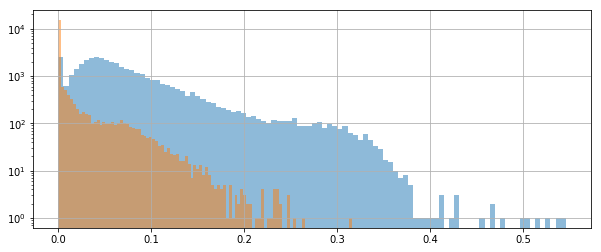

In [734]:
pd.Series(W.flatten()).hist(bins=100, log=True, alpha=0.5, figsize=(10,4))
pd.Series(W1.flatten()).hist(bins=100, alpha=0.5)

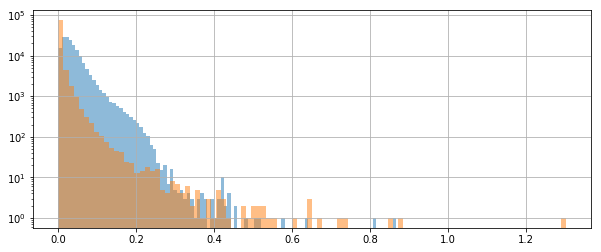

In [735]:
pd.Series(H.flatten()).hist(bins=100, log=True, alpha=0.5, figsize=(10,4))
pd.Series(H1.flatten()).hist(bins=100, alpha=0.5)

In [739]:
show_topics(H.T)

['sex motto pov cruel homosexuality tiff abortion library',
 'program ftp advance format files windows gif dos',
 'space launch lunar nasa satellite dc shuttle moon',
 'ico bobbe beauchaine bronx manhattan sank tek vice',
 'god jesus ra bible ye satan deletion malcolm',
 'objective morality values moral subjective absolute freedom science',
 'graphics comp amiga 3d aspects computer data radiosity',
 'cview file image files tiff temp format jpg',
 'card mode vesa jesus video driver vga spacecraft',
 'jesus cheers kent mormons christian jews christians conform',
 'atheism islam atheists muslims islamic allah rushdie atheist',
 'vesa card mode space driver 256 vga color',
 'people software mary dryden real shafer balls insisting',
 'edu cobb koresh wrong 9591 mcwilliams jim 517',
 'thanks just did objective claim software posts update',
 'does know men kent cheers islam mom cview',
 'software koresh evidence jim 3do fbi deletion newspaper',
 'question nasa gov egalon don kent animals data

In [628]:
show_topics(H1)

['don just think people like know ve good',
 'thanks advance know looking mail does help hi',
 'space nasa launch shuttle orbit lunar earth moon',
 'ico tek bobbe bronx beauchaine manhattan sank queens',
 'god jesus bible believe christian christ christians satan',
 'objective morality values moral subjective science absolute claim',
 'graphics comp software 3d edu computer group amiga',
 'files file image format gif tiff cview program',
 'islam atheism religion atheists evidence islamic does argument',
 'card mode vesa driver windows video vga color']

In [340]:
H1.shape

(10, 8356)

In [405]:
model.user_factors(torch.LongTensor(range(n_docs))).detach().norm()

tensor(5164.6338)

In [407]:
model.user_factors(torch.LongTensor(range(n_docs))).normal_(std=0.01).abs_()

tensor([[0.0006, 0.0061, 0.0036,  ..., 0.0046, 0.0118, 0.0052],
        [0.0128, 0.0046, 0.0082,  ..., 0.0170, 0.0055, 0.0025],
        [0.0166, 0.0015, 0.0204,  ..., 0.0058, 0.0081, 0.0064],
        ...,
        [0.0085, 0.0168, 0.0028,  ..., 0.0034, 0.0046, 0.0016],
        [0.0012, 0.0073, 0.0056,  ..., 0.0020, 0.0024, 0.0019],
        [0.0124, 0.0140, 0.0115,  ..., 0.0121, 0.0123, 0.0047]],
       grad_fn=<AbsBackward>)

In [414]:
model.user_factors(torch.LongTensor(range(n_docs))).detach().shape

torch.Size([2034, 10])

In [533]:
a = model.user_factors(torch.LongTensor(range(n_docs))).detach()